# Import

In [1]:
from quspin.basis import spin_basis_1d,photon_basis,boson_basis_1d,tensor_basis # Hilbert space bases
from quspin.operators import hamiltonian # Hamiltonian and observables
from quspin.tools.measurements import obs_vs_time,diag_ensemble # t_dep measurements
from quspin.tools.Floquet import Floquet,Floquet_t_vec # Floquet Hamiltonian
from quspin.basis.photon import coherent_state # HO coherent state
from quspin.tools.block_tools import block_diag_hamiltonian
import numpy as np # generic math functions
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pylab
import scipy.sparse.linalg as sparseLA
from numpy import linalg as LA
from scipy.special import comb
import time

In [2]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [3]:
%matplotlib widget

In [4]:
%matplotlib inline

# Model parameters

In [5]:
N_osc=4 #number of harmonic oscillators
N_lev=4 # number of energy levels of oscillators
N_tot=N_lev**N_osc # total number of states of all photons
freq_delta = 0.01
Omega=np.random.uniform(1.0-freq_delta,1.0+freq_delta,N_osc) # frequency of the oscillator
print(Omega)
A=0.1 # spin-photon coupling strength (drive amplitude)
Delta=0.5 # difference between atom energy levels

[0.99334644 1.00117999 1.00503875 1.005532  ]


In [6]:
N_ph_avg=N_lev//2

In [7]:
2*N_tot

512

# Hamiltonian of a two-state atom in a reservoir of harmonic oscillators 

For the purpose of our study, we take a two-level atom (i.e. a single-site spin chain) and couple it to multiple photon mode (i.e. a quantum harmonic oscillators). The Hamiltonian reads: 
$$ H = \sum_{k=1}^{N_{osc}} \Omega_k a_k^\dagger a_k + \frac{A}{2} \frac{1}{\sqrt{N_{ph~avg}}} \sum_k (a_k^\dagger + a_k) \sigma^x + \Delta \sigma^z$$
where the operator $a^\dagger$ creates a photon in the mode, and the atom is modelled by a two-level system described by the Pauli spin operators $\sigma^{x,y,z}$. 
$N_{osc}$ is the number of harmoniv oscillators in the reservoir, $N_{lev}$ - number of energy levels of a single photon mode.
The photon frequency is $\Omega$, $N_{ph}$ is the average number of photons in a single mode, $A$ - the coupling between the EM field $E=\sum_{k=1}^{N_{osc}}\sqrt{N_{ph~avg}^{-1}}(a_k^\dagger + a_k)$, and the dipole operator $\sigma^x$, and $\Delta$ measures the energy difference between the two atomic states.

To set up the spin-photon Hamiltonian, we first build the site-coupling lists. The ph_energy list does not require the specification of a lattice site index, since the latter is not defined forthe photon sector. The at_energy list, on the other hand, requires the input of the lattice sitefor the $\sigma^z$-operator:  since we consider a single two-level system or, equivalently – a single-site chain, this index is 0. The spin-photon coupling lists absorb and emit also require the site index which refers to the corresponding Pauli matrices: in this model – 0 again due to dimensional constraints.

In [8]:
# define operator site-coupling lists
ph_energy=[[Omega[i],i] for i in range(N_osc)] # photon energy
at_energy=[[Delta,0]] # atom energy, 0 because the "lattice" is single-site
absorb=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # absorption term
emit=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # emission term

To build the static operator list, we use the $|$ symbol in the operator string to distinguish the spin and photon operators: spin operators always come to the left of the $|$-symbol,  while photon operators - to the right. For convenience, the identity operator $I$ can be omitted, suchthat $I|n$ is the same as $|n$, and $z|I$ is equivalent to $z|$, respectively. The dynamic list is empty since the spin-photon Hamiltonian is time-independent.

In [9]:
# define static and dynamics lists
static_no_interaction=[["|n",ph_energy],["z|",at_energy]]
static_rotating_wave=[["|n",ph_energy],["+|-",absorb],["-|+",emit],["z|",at_energy]]
static_full=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]
dynamic=[]

To build the spin-photon basis, we call the function photon_basis and use spin_basis_1d as the first argument. We need to specify the number of spin lattice sites, and the total numberof harmonic oscillator (a.k.a photon) states.

In [10]:
basis_osc = boson_basis_1d(L=N_osc, sps=N_lev)
#print(basis_osc)

In [11]:
# compute atom-photon basis
#basis_photon_particle=photon_basis(spin_basis_1d, L=1, Nph=L_lev)
basis_osc = boson_basis_1d(L=N_osc,sps=N_lev)
basis_spin = spin_basis_1d(L=1, pauli=-1, S="1/2")
basis = tensor_basis(basis_spin,basis_osc) 
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
	  0.         |1>           1         |3 3 3 3>           255  
	  1.         |1>           1         |3 3 3 2>           254  
	  2.         |1>           1         |3 3 3 1>           253  
	  3.         |1>           1         |3 3 3 0>           252  
	  4.         |1>           1         |3 3 2 3>           251  
	  5.         |1>           1         |3 3 2 2>           250  
	  6.         |1>           1         |3 3 2 1>           249  
	  7.         |1>           1         |3 3 2 0>           248  
	  8.         |1>           1         |3 3 1 3>           247  
	  9.         |1>           1         |3 3 1 2>           246  
	 10.         |1>           1         |3 3 1 1>           245  
	 11.         |1>           1         |3 3 1 0>           244  
	 12.         |1>           1         |3 3 0 3>           243  
	 13.         |1>           1         |3 3 0 2>           242  
	 14.         |1>           1      

In [12]:
# import inspect
# inspect.getmembers(tensor_basis)

In [13]:
# compute atom-photon Hamiltonian H
H_no_interaction=hamiltonian(static_no_interaction,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_full=hamiltonian(static_full,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_rotating_wave=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

In [14]:
#print('Number of states of Hamiltonian:', H_rotating_wave.Ns)

# Spectrum 

In [15]:
# calculate entire spectrum only
start = time.time()
eigenvalues_H_no_interaction=H_no_interaction.eigvalsh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.027782917022705078


In [16]:
start = time.time()
eigenvalues_H_full=H_full.eigvalsh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.03554081916809082


In [17]:
start = time.time()
eigenvalues_H_rotating_wave, eigenvectors_H_rotating_wave = H_rotating_wave.eigh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.11569094657897949


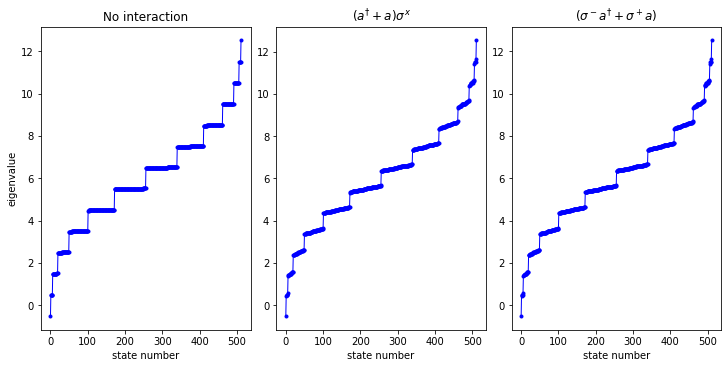

In [18]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
x = np.arange(H_no_interaction.Ns)
ax[0].plot(x,eigenvalues_H_no_interaction, '.-', color='b', lw=1.)
ax[1].plot(x,eigenvalues_H_full, '.-', color='b', lw=1.)
ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
# for level in x :
#     ax[0].plot(x,np.full(H_no_interaction.Ns,eigenvalues_H_no_interaction[level]), '-', color='b', lw=0.5)
#     ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
#     ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='$(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()

# Definitions: blocks and eigenvalues

In [19]:
# size of of the particle-conserved basis of bosons
def boson_block_size(N_sites, N_levels, N_particles):
    Ns=0
    for r in range(N_particles//N_levels+1):
        r_2 = N_particles - r*N_levels
        if r % 2 == 0:
            Ns +=  comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
        else:
            Ns += -comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
    return Ns

In [20]:
def size_of_matrix_to_diagonalize_block(N_sites, N_levels, N_block):
    return boson_block_size(N_sites, N_levels, N_block-1)+boson_block_size(N_sites, N_levels, N_block)

In [21]:
size_of_matrix_to_diagonalize_block(10, 10, 10)

140988

In [22]:
def hamitonian_one_block(N_block, static_list, dynamic_list, sparse=False) :
    # generate projection of boson basis with chosen number of particles: N_block and N_block-1
    basis_osc_block = boson_basis_1d(L=N_osc, Nb={N_block,N_block-1}, sps=N_lev)    
    # mixed atom-boson basis
    combined_basis_block = tensor_basis(basis_spin,basis_osc_block)                 

    # generate boson sub-basis with N_block particles
    basis_osc_block_n = boson_basis_1d(L=N_osc, Nb={N_block}, sps=N_lev)     # part of boson basis
    # find indices of states with N_block particles in basis_osc_block. these states correcpond to spin-down part of the block
    selected_indices_n_down_spin = 2*len(basis_osc_block.states) - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n.states) - 1   
    boson_states_spin_down = np.copy(basis_osc_block_n.states)
    
    # generate boson sub-basis with N_block-1 particles
    basis_osc_block_n_minus_1 = boson_basis_1d(L=N_osc, Nb={N_block-1}, sps=N_lev)     # part of boson basis
    # find indices of states with N_block-1 particles in basis_osc_block. these states correcpond to spin-up part of the block
    selected_indices_n_minus_1_up_spin = len(basis_osc_block.states) - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n_minus_1.states) - 1  
    boson_states_spin_up = np.copy(basis_osc_block_n_minus_1.states)
    
    all_selected_indices = np.concatenate((selected_indices_n_minus_1_up_spin, selected_indices_n_down_spin))  
        
    if sparse :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=combined_basis_block, check_symm=False, check_pcon=False, check_herm=False).tocsc()
    else :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=combined_basis_block, check_symm=False, check_pcon=False, check_herm=False).toarray()
    
    ixgrid = np.ix_(all_selected_indices, all_selected_indices)
    hamiltonian_reduced = hamiltonian_full[ixgrid]
    
    nb_of_prev_states = np.sum([(size_of_matrix_to_diagonalize_block(N_osc, N_lev, n)) for n in range(0,N_block)])
    states = np.arange(nb_of_prev_states+1*sparse, nb_of_prev_states+hamiltonian_reduced.shape[0])
    
    del hamiltonian_full, all_selected_indices, selected_indices_n_minus_1_up_spin, selected_indices_n_down_spin

    return hamiltonian_reduced, states, boson_states_spin_down, boson_states_spin_up

In [23]:
def matrix_eigenvalues(matrix, sparse=False) :
    if sparse :
        eigenvals, eigenvectors = sparseLA.eigsh(matrix,k=matrix.shape[0]-1)
    else :
        eigenvals, eigenvectors = LA.eigh(matrix)   # for dense matrices
    return eigenvals, eigenvectors

In [24]:
def hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list) :
    if (size_of_matrix_to_diagonalize_block(N_osc, N_lev, N_block) < 1000) :
        sparse = False
    else :
        sparse = True  
    hamiltonian, states, boson_states_spin_down, boson_states_spin_up = hamitonian_one_block(N_block, static_list, dynamic_list, sparse)
    start = time.time()
    eigenvals, eigenvectors = matrix_eigenvalues(hamiltonian, sparse)
    end = time.time()
    print('N_photons=%2.0f, size of the reduced matrix=%2.0f, diagonalization runtime=%2.6e' % (N_block, len(eigenvals), (end-start))) 
    return eigenvals, eigenvectors, states, boson_states_spin_down, boson_states_spin_up

## Data structure (define array of dictionaries)

In [25]:
def get_all_blocks_hamiltonian_dictionary(static_list, dynamic_list) :
    blocks = [] 
    for N_block in range(0,(N_lev-1)*N_osc) : 
        b = dict()
        b['index_of_block'] = N_block
        b['eigenvals'], b['eigenvectors'], b['states'], b['boson_states_spin_down'], b['boson_states_spin_up'] = hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list)
        b['size'] = len(b['eigenvals'])
        blocks.append(b)
    return blocks

# Compute diagonalized blocks (create dictionaries)

In [26]:
blocks_no_interaction = get_all_blocks_hamiltonian_dictionary(static_no_interaction, dynamic)

N_photons= 0, size of the reduced matrix= 1, diagonalization runtime=6.794930e-05
N_photons= 1, size of the reduced matrix= 5, diagonalization runtime=1.311302e-04
N_photons= 2, size of the reduced matrix=14, diagonalization runtime=5.745888e-05
N_photons= 3, size of the reduced matrix=30, diagonalization runtime=8.344650e-05
N_photons= 4, size of the reduced matrix=51, diagonalization runtime=5.745888e-04
N_photons= 5, size of the reduced matrix=71, diagonalization runtime=9.716749e-03
N_photons= 6, size of the reduced matrix=84, diagonalization runtime=1.286983e-03
N_photons= 7, size of the reduced matrix=84, diagonalization runtime=9.248257e-04
N_photons= 8, size of the reduced matrix=71, diagonalization runtime=7.734299e-04
N_photons= 9, size of the reduced matrix=51, diagonalization runtime=3.216267e-04
N_photons=10, size of the reduced matrix=30, diagonalization runtime=8.130074e-05
N_photons=11, size of the reduced matrix=14, diagonalization runtime=6.651878e-05


In [27]:
blocks_rotating_wave = get_all_blocks_hamiltonian_dictionary(static_rotating_wave, dynamic)

N_photons= 0, size of the reduced matrix= 1, diagonalization runtime=7.033348e-05
N_photons= 1, size of the reduced matrix= 5, diagonalization runtime=1.473427e-04
N_photons= 2, size of the reduced matrix=14, diagonalization runtime=8.545876e-03
N_photons= 3, size of the reduced matrix=30, diagonalization runtime=1.212120e-03
N_photons= 4, size of the reduced matrix=51, diagonalization runtime=8.980751e-03
N_photons= 5, size of the reduced matrix=71, diagonalization runtime=1.131535e-03
N_photons= 6, size of the reduced matrix=84, diagonalization runtime=4.594326e-03
N_photons= 7, size of the reduced matrix=84, diagonalization runtime=2.326488e-03
N_photons= 8, size of the reduced matrix=71, diagonalization runtime=2.328134e-02
N_photons= 9, size of the reduced matrix=51, diagonalization runtime=1.214981e-03
N_photons=10, size of the reduced matrix=30, diagonalization runtime=5.302429e-04
N_photons=11, size of the reduced matrix=14, diagonalization runtime=2.021790e-04


# Compare spectrum of blocks with the full one

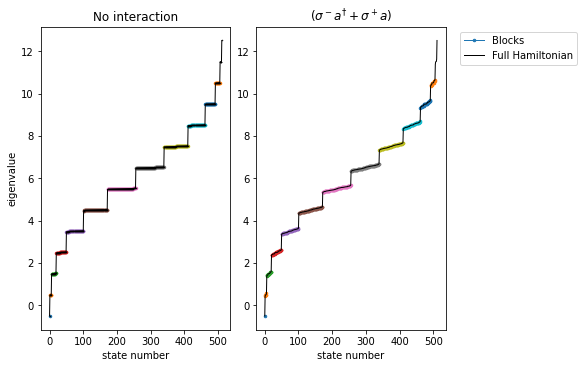

In [28]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(8,5))

#no interation
for i,b in enumerate(blocks_no_interaction) :
    ax[0].plot(b['states'], b['eigenvals'], '.-', lw=1., ms=5.0)
ax[0].plot(np.arange(H_no_interaction.Ns),eigenvalues_H_no_interaction, '.-', color='k', lw=1., ms=1.0)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue');

# rotating wave approx
for i,b in enumerate(blocks_rotating_wave) :
    ax[1].plot(b['states'], b['eigenvals'], '.-', lw=1., ms=5.0, label=('Blocks' if i==0 else ''))
ax[1].plot(eigenvalues_H_rotating_wave, '-', color='k', lw=1., ms=1.0, label='Full Hamiltonian')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); 
plt.show()

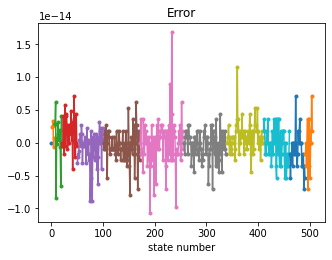

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
for i, block in enumerate(blocks_rotating_wave) :
    x = np.array(block['states'], dtype=int)
    ax.plot(x, block['eigenvals']-eigenvalues_H_rotating_wave[x], '.-')
ax.set(title='Error', xlabel='state number')
plt.show()

In [55]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
# N_block={3,4,5}
# for i in N_block :  
#     ax.plot(blocks_rotating_wave[i]['states'], blocks_rotating_wave[i]['eigenvals'], '.-')
# ax.set(title=r'Three blocks $N_b$=' + str(N_block), xlabel='state number', ylabel='eigenvalue'); ax.grid()
# plt.show()

In [31]:
# for i, block in enumerate(blocks_rotating_wave[4:5]) :
#     for state in block['boson_states_spin_up'] :
#         print(basis_osc.int_to_state(state))

In [32]:
# for i, block in enumerate(blocks_rotating_wave[4:5]) :
#     for state in block['boson_states_spin_down'] :
#         print(basis_osc.int_to_state(state))

# Observables computed from eigenvectors

In [33]:
def get_occupancy_on_site(site_index_array, state_int_array, sps) :
    xx, yy = np.meshgrid(site_index_array, state_int_array, indexing='ij')
    return (yy//sps**xx)%sps

Computation of observables : long version 

In [34]:
# for i, block in enumerate(blocks_rotating_wave) :
#     # collect integer representations of the fock states of bosonic part of reduced block basis
#     state_integers = np.concatenate((block['boson_states_spin_up'], block['boson_states_spin_down']))
#     # mean occupancy and its fluctuation at each site of the photon-lattice
#     block['ni_mean'] = np.zeros([N_osc, block['size']]); block['ni_fluct'] = np.zeros([N_osc, block['size']])
    
#     for site_index in range(N_osc) : 
#         mean = np.zeros(block['size']); mean_sqr = np.zeros(block['size'])
#         for eigenvector_index, eigenvector in enumerate(block['eigenvectors'].T) : # loop over matrix columns
#             block['ni_mean'][site_index, eigenvector_index] = np.sum(get_occupancy_on_site(site_index,state_integers,N_lev)*eigenvector**2)
#             block['ni_fluct'][site_index, eigenvector_index] = np.sum((get_occupancy_on_site(site_index,state_integers,N_lev)**2)*eigenvector**2)
#     block['ni_fluct'] = block['ni_fluct'] - block['ni_mean']**2

#     # average atom spin
#     spins = 0.5*np.concatenate((np.full(len(block['boson_states_spin_up']),1.), np.full(len(block['boson_states_spin_down']),-1.))) 
#     block['spin_mean'] = np.zeros(block['size'])
#     for eigenvector_index, eigenvector in enumerate(block['eigenvectors'].T) : # loop over matrix columns        
#         block['spin_mean'][eigenvector_index] = np.sum(spins*eigenvector**2)

The same computation, but with the use of python numpy dot product function instead of "for"-loops  :

In [35]:
for i, block in enumerate(blocks_rotating_wave) :
    state_integers = np.concatenate((block['boson_states_spin_up'], block['boson_states_spin_down']))
    
    # mean occupancy and its fluctuation at each site of the photon-lattice
    block['ni_mean'] = np.dot(get_occupancy_on_site(range(N_osc),state_integers,N_lev),(block['eigenvectors']**2))
    block['ni_fluct'] = np.dot((get_occupancy_on_site(range(N_osc),state_integers,N_lev)**2),(block['eigenvectors']**2)) - block['ni_mean']**2
    
    # average atom spin
    spins = np.concatenate((np.full(len(block['boson_states_spin_up']),1.), np.full(len(block['boson_states_spin_down']),-1.))) 
    block['spin_mean'] = np.dot(spins, block['eigenvectors']**2)

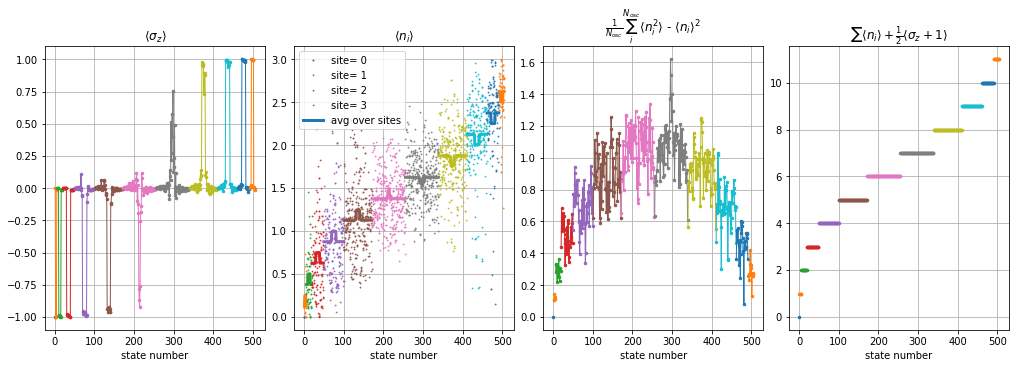

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(14,5))

for i, block in enumerate(blocks_rotating_wave) :
    block_color = colors[i%len(colors)]
    ax[0].plot(block['states'], block['spin_mean'], '.-', lw=1., ms=5.0, color=block_color)
    for site in range(N_osc) :
        ax[1].plot(block['states'], block['ni_mean'][site,:], marker=Line2D.filled_markers[site], lw=0, ms=1., color=block_color, label='site=%2.0f'%site)
    ax[1].plot(block['states'], np.mean(block['ni_mean'], axis=0), '-', lw=3., color=block_color, label='avg over sites')
    if i==0 : ax[1].legend()
    ax[2].plot(block['states'], np.mean(block['ni_fluct'], axis=0), '.-', lw=1., ms=5.0, color=block_color)
    ax[3].plot(block['states'], np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1), '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\langle \sigma_z \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title=r'$\langle n_i \rangle$', xlabel='state number'); ax[1].grid()
ax[2].set(title=r'$\frac{1}{N_{osc}}\sum_{i}^{N_{osc}}\langle n_i^2 \rangle$ - $\langle n_i \rangle^2$', xlabel='state number'); ax[2].grid()
ax[3].set(title=r'$\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$', xlabel='state number'); ax[3].grid()
plt.show()

# Matrices of operators

## Operators applied to the full Hamiltonian basis

In [39]:
sigma_z_operator_full = hamiltonian([["z|",[[1.,0]]]],[],dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
n_operator_full = hamiltonian([["|n",[[1.,i] for i in range(N_osc)]]],[],dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

mean_full_sigma_z = sigma_z_operator_full.expt_value(eigenvectors_H_rotating_wave, enforce_pure=True)
mean_full_n = n_operator_full.expt_value(eigenvectors_H_rotating_wave, enforce_pure=True)

## Operators applied to block basis

In [40]:
for i, block in enumerate(blocks_rotating_wave) :
    block['sigma_z_operator_matrix'] = hamitonian_one_block(block['index_of_block'], [["z|",[[1.,0]]]], [], sparse=False)[0]
    block['n_operator_matrix'] = hamitonian_one_block(block['index_of_block'], [["|n",[[1.,i] for i in range(N_osc)]]], [], sparse=False)[0]
    block['mean_sigma_z_operator_matrix'] = np.empty(block['size'])
    block['mean_n_operator_matrix'] = np.empty(block['size'])
    for state_index, eigenvector in enumerate(block['eigenvectors'].T) :    # loop over eigenvectors (matrix columns)
        block['mean_sigma_z_operator_matrix'][state_index] = np.dot(eigenvector.T, np.dot(block['sigma_z_operator_matrix'],eigenvector))
        block['mean_n_operator_matrix'][state_index] = np.dot(eigenvector.T, np.dot(block['n_operator_matrix'],eigenvector))

# Plot and compare

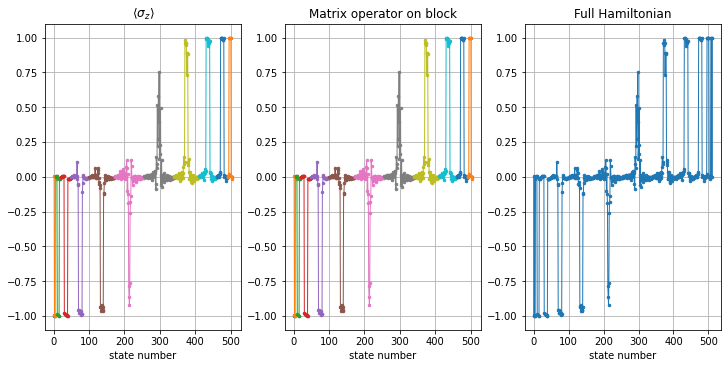

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], block['spin_mean'], '.-', lw=1., ms=5.0)
    ax[1].plot(block['states'], block['mean_sigma_z_operator_matrix'], '.-', lw=1., ms=5.0)
# ax[0].plot(mean_full_sigma_z, '-', lw=0.5, color='k')
# ax[1].plot(mean_full_sigma_z, '-', lw=0.5, color='k')
ax[2].plot(mean_full_sigma_z, '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\langle \sigma_z \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

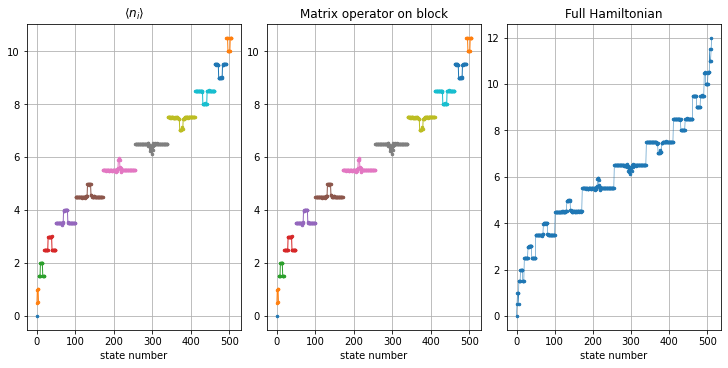

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], np.sum(block['ni_mean'], axis=0), '.-', lw=1., ms=5.0)
    ax[1].plot(block['states'], block['mean_n_operator_matrix'], '.-', lw=1., ms=5.0)
# ax[0].plot(mean_full_n, '-', lw=0.5, color='k')
# ax[1].plot(mean_full_n, '-', lw=0.5, color='k')
ax[2].plot(mean_full_n, '.-', lw=0.5, ms=5.0)
ax[0].set(title=r'$\langle n_i \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

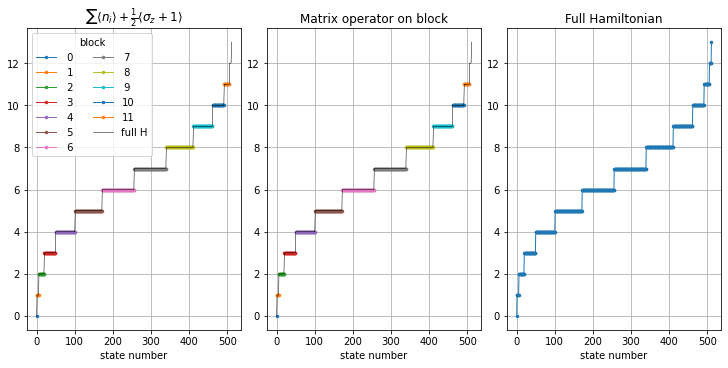

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1), '.-', lw=1., ms=5.0, label='%2.0f'%i)
    ax[1].plot(block['states'], block['mean_n_operator_matrix'] + 0.5*(block['mean_sigma_z_operator_matrix']+1), '.-', lw=1., ms=5.0)
ax[0].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '-', lw=0.5, color='k', label='full H')
ax[1].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '-', lw=0.5, color='k')
ax[2].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$', xlabel='state number'); ax[0].grid()
ax[0].legend(title='block', ncol=2)
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

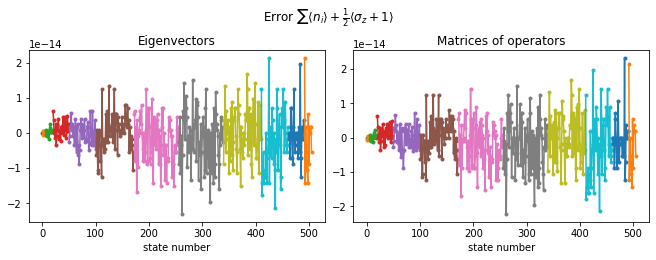

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(9,3.5))
fig.suptitle(r'Error $\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$')
for i, block in enumerate(blocks_rotating_wave) :
    x = np.array(block['states'], dtype=int)
    ax[0].plot(x, np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1)- (mean_full_n[x] + 0.5*(mean_full_sigma_z[x]+1)), '.-')
    ax[1].plot(x, block['mean_n_operator_matrix'] + 0.5*(block['mean_sigma_z_operator_matrix']+1)- (mean_full_n[x] + 0.5*(mean_full_sigma_z[x]+1)), '.-')
ax[0].set(title='Eigenvectors', xlabel='state number')
ax[1].set(title='Matrices of operators', xlabel='state number')
plt.show()